# YOLO7 Pose Detection

---

## References 

Notebook for extracting/plotting keypoints:
- https://github.com/WongKinYiu/yolov7/blob/main/tools/keypoint.ipynb

Guidance for keypoint output:
- https://stackoverflow.com/questions/75121807/what-are-keypoints-in-yolov7-pose

Yolo github (see plot_skeleton_kpts for coordinates):
- https://github.com/WongKinYiu/yolov7/blob/main/utils/plots.py

Yolo code examples:

- https://stackabuse.com/pose-estimation-and-keypoint-detection-with-yolov7-in-python/

- https://www.kaggle.com/code/parapapapam/yolov7-keypoints-demo/notebook

MediaPipe vs Yolo code examples:
- https://learnopencv.com/yolov7-pose-vs-mediapipe-in-human-pose-estimation/



## Notes for Paper:

Paper reference here: 
- https://arxiv.org/pdf/2204.06806.pdf

**Normalization in paper:**

[3.2 Anchor based multi-person pose formulation]

For a given image, an anchor that is matched against a
person stores its entire 2D pose along with bounding box.
The box coordinates are transformed w.r.t the anchor
center whereas box dimensions are normalized against
height and width of the anchor. Similarly, keypoint
locations are transformed w.r.t to anchor center. However,
Keypoints aren’t normalized with anchor height and width.
Both Key-point and box are predicted w.r.t to the center of
the anchor. Since our enhancement is independent of
anchor width and height, it can be easily extended to
anchor-free object detection approaches like YOLOX

**Keypoints outside of the bounding box, i.e. shoulder down**

[3.6. Keypoint Outside Bounding Box]

Top-down approaches perform poorly under occlusion.
One of the advantages of YOLO-Pose over top-down
approaches is there is no constraint for the keypoints to be
inside the predicted bounding box. Hence, if keypoints lie
outside the bounding box because of occlusion, they can
still be correctly recognized. Whereas, in top-down
approaches, if the person detection is not correct, pose
estimation will fail as well. Both these challenges of
occlusion and incorrect box detection are mitigated to some
extent in our approach as shown in Figure 3.

# 1. Load Dependencies

In [1]:
! git clone https://github.com/WongKinYiu/yolov7.git

fatal: destination path 'yolov7' already exists and is not an empty directory.


In [2]:
%cd yolov7

/Users/johngalvin/Downloads/yolov7


In [3]:
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7-w6-pose.pt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  153M  100  153M    0     0  3099k      0  0:00:50  0:00:50 --:--:-- 3300k    0  3035k      0  0:00:51  0:00:24  0:00:27 2984k    0     0  2933k      0  0:00:53  0:00:30  0:00:23 2646k   0  3084k      0  0:00:51  0:00:46  0:00:05 3443k


In [4]:
import torch
import torchvision
from torchvision import transforms
import tqdm

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

import matplotlib.pyplot as plt
import cv2
import numpy as np
# from roboflow import Roboflow
import os

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
torch.cuda.empty_cache()

# 2. Data Pre-Processing

End result will be a pytorch dataset so we dont have to rerun the pre-processing

In [6]:
## Load Model 
def load_model():
    model = torch.load('yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    else:
        model.to(device)
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model()

### Check for keypoints used

In [7]:
print(model.yaml['nkpt'])

17


In [8]:
def run_inference(image_in):

    image = letterbox(image_in, 960, stride=64, auto=True)[0]
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
  
    output, _ = model(image)
    output = output[0][0][6:] # keep just x,y,z for 17 keypoints
    output = torch.reshape(output, (17,3))
    output = torch.cat((output[0], output[1], output[2], output[5], 
                        output[14], output[15], output[16])) # upper body
    output = torch.reshape(output, (7,3))
    
    # Rescale keypoints
    shoulder_avg = output[2:4].mean(axis=0)
    numerator = output - shoulder_avg
    sqd = (output - shoulder_avg)**2
    x = sqd[:, 0]
    y = sqd[:, 1]
    distances = torch.sqrt(x+y)
    idx = int(torch.argmax(distances))
    point_max_d = output[idx]
    output = numerator / point_max_d
    
    return output, image

## Import Data 

In [9]:
label_dict = {
    'looks good':0.0,
    'sit up':1.0
    }

In [10]:
train_dir = "/Users/johngalvin/Desktop/posture_correction_v4-1/train"
val_dir = "/Users/johngalvin/Desktop/posture_correction_v4-1/valid"
test_dir = "/Users/johngalvin/Desktop/posture_correction_v4-1/test"

In [11]:
test_pic_path = "/Users/johngalvin/Desktop/posture_correction_v4-1/train/looks good/extract0002_jpg.rf.89be3255bdcbb5232af153a7743749fd.jpg"

In [12]:
test_pic = cv2.imread(test_pic_path)

In [13]:
out, _ = run_inference(test_pic)
out

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-0.46433, -0.03062, -0.64689],
        [-0.14116, -0.16074, -0.39775],
        [-0.84505, -0.07173, -0.52681],
        [ 0.84505,  0.07173,  0.52681],
        [-0.82268,  0.92637, -0.16682],
        [ 0.07421,  1.33100,  0.06876],
        [-1.01197,  1.20524,  0.07320]], grad_fn=<DivBackward0>)

In [14]:
X_train, Y_train = [], []

rootdir = train_dir

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        fpath = os.path.join(subdir, file)
        img = cv2.imread(fpath)
        with torch.no_grad():
            output, _ = run_inference(img)
        X_train.append(output)
        label = subdir.split("/")[-1]
        Y_train.append(label_dict[label])  

In [15]:
X_val, Y_val = [], []

rootdir = val_dir

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        fpath = os.path.join(subdir, file)
        img = cv2.imread(fpath)
        with torch.no_grad():
            output, _ = run_inference(img)
        X_val.append(output)
        label = subdir.split("/")[-1]
        Y_val.append(label_dict[label]) 

In [17]:
Y_train = torch.tensor(Y_train)
Y_val = torch.tensor(Y_val)

In [18]:
## coerce data into a pytorch dataset object

from torch.utils.data import Dataset
 
class KeyPointDataset(Dataset):
 
    def __init__(self,data,label):
        self.keypoint_data = data
        self.posture_label = label
     
    # The length of the dataset
    def __len__(self):
        return len(self.keypoint_data)
 
    # Load of item in folder
    def __getitem__(self, index):
        sample = self.keypoint_data[index]
        label = self.posture_label[index]
        return sample, label

In [19]:
# file_label_ds is a dataset that gives you the file name and label.
train_set = KeyPointDataset(X_train, Y_train)
val_set = KeyPointDataset(X_val, Y_val)

In [29]:
# check what train_set.keypoint_data looks like

print ("size of each sample:", train_set.keypoint_data[0].shape)

size of each sample: torch.Size([7, 3])


# 3. Run Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [353]:
import torch.nn as nn
import torch.nn.functional as F

class Classification_Network(nn.Module):

    def __init__(self):
        super(Classification_Network, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

model = Classification_Network()
print(model)

Classification_Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [354]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [355]:
# Hyperparameters
LOSS = torch.nn.BCELoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 100
BATCH_SIZE = 16

# Data loaders
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, BATCH_SIZE, shuffle=True)

In [356]:
# Training Loop

epoch_losses_train = []
epoch_losses_val = []
epoch_accuracy_train = []
epoch_accuracy_val = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    
    train_batch_losses = []
    train_num_correct = 0
    model.train()
    
    # Training
    for data, labels in tqdm(train_loader):
        OPTIMIZER.zero_grad()
        data, labels = data.to(device), labels.to(device)
        preds = model(data)
        preds = torch.flatten(preds)
        train_loss = LOSS(preds, labels)
        train_batch_losses.append(train_loss.item())
        train_loss.backward()
        OPTIMIZER.step()
        
        #Accuracy
        classes_train = torch.where(preds > 0.5, torch.tensor(1.), torch.tensor(0.))
        hits_train = torch.where(classes_train == labels, 1, 0)
        train_num_correct += int(sum(hits_train))
        train_batch_acc.append(train_acc)
        
    epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
    epoch_losses_train.append(epoch_train_loss)
    epoch_train_acc = train_num_correct / len(train_set)
    epoch_accuracy_train.append(epoch_train_acc)
    print ("Train Loss:", epoch_train_loss, "Train Accuracy:", epoch_train_acc)
    
    # Validation
    model.eval()
    val_batch_losses = []
    val_num_correct = 0
    
    for data, labels in tqdm(val_loader):
        data, labels = data.to(device), labels.to(device)
        
        with torch.no_grad():
            preds = model(data)
            preds = torch.flatten(preds)
        
        val_loss = LOSS(preds, labels)
        val_batch_losses.append(val_loss.item())
        
        #Accuracy
        classes_val = torch.where(preds > 0.5, torch.tensor(1.), torch.tensor(0.))
        hits_val = torch.where(classes_val == labels, 1, 0)
        val_num_correct += int(sum(hits_val))
        val_batch_acc.append(val_acc)
                              
    epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
    epoch_losses_val.append(epoch_val_loss)
    epoch_val_acc = val_num_correct / len(val_set)
    epoch_accuracy_val.append(epoch_val_acc)
    print ("Val Loss:", epoch_val_loss, "Val Accuracy:", epoch_val_acc)

Epoch 1/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5723762503772412 Train Accuracy: 0.7387201415511648


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5942073600987593 Val Accuracy: 0.7225130890052356
Epoch 2/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5545105973504624 Train Accuracy: 0.7387201415511648


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5866710046927134 Val Accuracy: 0.7225130890052356
Epoch 3/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5408525424745848 Train Accuracy: 0.7384252432910646


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5785404114673535 Val Accuracy: 0.7225130890052356
Epoch 4/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.534464965521727 Train Accuracy: 0.7449130050132704


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5881470848495761 Val Accuracy: 0.725130890052356
Epoch 5/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5320892250341065 Train Accuracy: 0.7508109702152758


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5723352966209253 Val Accuracy: 0.725130890052356
Epoch 6/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5245913123747088 Train Accuracy: 0.7525803597758773


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5740647663672765 Val Accuracy: 0.743455497382199
Epoch 7/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5203238634287186 Train Accuracy: 0.752285461515777


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6048612827435136 Val Accuracy: 0.7198952879581152
Epoch 8/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5195581475097053 Train Accuracy: 0.75552934237688


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5905899877349535 Val Accuracy: 0.7290575916230366
Epoch 9/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5122491424938418 Train Accuracy: 0.7534650545561781


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5829476652046045 Val Accuracy: 0.725130890052356
Epoch 10/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5153886623821169 Train Accuracy: 0.7634915953995871


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5951483647028605 Val Accuracy: 0.7421465968586387
Epoch 11/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.508447158449101 Train Accuracy: 0.7596579180182836


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5987397879362106 Val Accuracy: 0.7395287958115183
Epoch 12/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5063258502280937 Train Accuracy: 0.7617222058389855


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5905359548827013 Val Accuracy: 0.7277486910994765
Epoch 13/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5026470869076702 Train Accuracy: 0.7634915953995871


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5743303044388691 Val Accuracy: 0.7408376963350786
Epoch 14/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5023487964469306 Train Accuracy: 0.761132409318785


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5967786554247141 Val Accuracy: 0.7421465968586387
Epoch 15/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5010832609292472 Train Accuracy: 0.759952816278384


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6197098270058632 Val Accuracy: 0.7382198952879581
Epoch 16/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.5002549799545756 Train Accuracy: 0.7670303745207904


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6136355636020502 Val Accuracy: 0.7460732984293194
Epoch 17/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.49371287360225086 Train Accuracy: 0.7664405780005898


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6260635182261467 Val Accuracy: 0.743455497382199
Epoch 18/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4951932434484644 Train Accuracy: 0.7664405780005898


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5890033158163229 Val Accuracy: 0.7408376963350786
Epoch 19/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4926879294919518 Train Accuracy: 0.7714538484222944


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6213721077268323 Val Accuracy: 0.7342931937172775
Epoch 20/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.49329306930303574 Train Accuracy: 0.7670303745207904


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.573585486660401 Val Accuracy: 0.7369109947643979
Epoch 21/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.48672356639268266 Train Accuracy: 0.771158950162194


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5843449762711922 Val Accuracy: 0.7473821989528796
Epoch 22/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.48525779961415055 Train Accuracy: 0.774402831023297


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5610725364337364 Val Accuracy: 0.7369109947643979
Epoch 23/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.48739014439425377 Train Accuracy: 0.7720436449424949


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6149976712961992 Val Accuracy: 0.7408376963350786
Epoch 24/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.48637524661871623 Train Accuracy: 0.7696844588616927


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6035629237691561 Val Accuracy: 0.7356020942408377
Epoch 25/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.481216550857391 Train Accuracy: 0.7752875258035977


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5848995583752791 Val Accuracy: 0.743455497382199
Epoch 26/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.48080524064178737 Train Accuracy: 0.7679150693010911


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5991214774549007 Val Accuracy: 0.7395287958115183
Epoch 27/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4839544896528406 Train Accuracy: 0.7767620171040991


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5976058322315415 Val Accuracy: 0.7382198952879581
Epoch 28/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.47925165576754875 Train Accuracy: 0.7764671188439988


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5944011947140098 Val Accuracy: 0.743455497382199
Epoch 29/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4754531372268245 Train Accuracy: 0.7797109997051017


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6182127225523194 Val Accuracy: 0.7408376963350786
Epoch 30/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.47500355204321304 Train Accuracy: 0.7820701857859038


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.612789049744606 Val Accuracy: 0.7342931937172775
Epoch 31/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4761360227921099 Train Accuracy: 0.7779416101445001


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5899257268756628 Val Accuracy: 0.7290575916230366
Epoch 32/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.47481002644547876 Train Accuracy: 0.7850191683869066


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5905796121805906 Val Accuracy: 0.743455497382199
Epoch 33/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46966800459151 Train Accuracy: 0.7805956944854026


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.671788616416355 Val Accuracy: 0.7369109947643979
Epoch 34/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4718026012041659 Train Accuracy: 0.7870834562076083


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6034190263599157 Val Accuracy: 0.7395287958115183
Epoch 35/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4694176302203592 Train Accuracy: 0.7829548805662047


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5869320277124643 Val Accuracy: 0.7303664921465969
Epoch 36/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4647390515596237 Train Accuracy: 0.7882630492480094


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5991276397059361 Val Accuracy: 0.7264397905759162
Epoch 37/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46348411667178263 Train Accuracy: 0.7909171335889118


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.603880200535059 Val Accuracy: 0.7369109947643979
Epoch 38/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46487439430828364 Train Accuracy: 0.7876732527278089


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5895146342615286 Val Accuracy: 0.7369109947643979
Epoch 39/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46883095280741743 Train Accuracy: 0.7847242701268062


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6032086374859015 Val Accuracy: 0.731675392670157
Epoch 40/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46429658568692656 Train Accuracy: 0.7918018283692126


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5936058896283308 Val Accuracy: 0.7303664921465969
Epoch 41/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46006112159141954 Train Accuracy: 0.7841344736066057


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5972429718822241 Val Accuracy: 0.731675392670157
Epoch 42/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.46022143974056784 Train Accuracy: 0.7859038631672073


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5992908005913099 Val Accuracy: 0.7356020942408377
Epoch 43/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4558739276989451 Train Accuracy: 0.7950457092303156


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7149676413585743 Val Accuracy: 0.7408376963350786
Epoch 44/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.45718672780214614 Train Accuracy: 0.7935712179298142


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.5818052344645063 Val Accuracy: 0.7342931937172775
Epoch 45/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.44991364516317844 Train Accuracy: 0.7962253022707166


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6167322068164746 Val Accuracy: 0.731675392670157
Epoch 46/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.45421780779395465 Train Accuracy: 0.7947508109702153


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6627620744208494 Val Accuracy: 0.7277486910994765
Epoch 47/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4479769769142259 Train Accuracy: 0.7976997935712179


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6644097296521068 Val Accuracy: 0.7395287958115183
Epoch 48/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.45367471437971546 Train Accuracy: 0.7926865231495134


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.635487251294156 Val Accuracy: 0.7447643979057592
Epoch 49/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.45104675423705354 Train Accuracy: 0.7971099970510174


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6477990237375101 Val Accuracy: 0.7369109947643979
Epoch 50/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4437949895718188 Train Accuracy: 0.7994691831318195


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6035823654383421 Val Accuracy: 0.7303664921465969
Epoch 51/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.44321773988458346 Train Accuracy: 0.8009436744323208


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6139868547519048 Val Accuracy: 0.743455497382199
Epoch 52/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.44421660956346765 Train Accuracy: 0.7962253022707166


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.616395590826869 Val Accuracy: 0.7447643979057592
Epoch 53/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.444185114342649 Train Accuracy: 0.7953406074904158


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.686214296768109 Val Accuracy: 0.7303664921465969
Epoch 54/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4405521403224963 Train Accuracy: 0.7994691831318195


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6957480066145459 Val Accuracy: 0.743455497382199
Epoch 55/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.43799457129723623 Train Accuracy: 0.8012385726924212


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6426781779155135 Val Accuracy: 0.731675392670157
Epoch 56/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.437597735521366 Train Accuracy: 0.7968150987909172


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6731069811309377 Val Accuracy: 0.7356020942408377
Epoch 57/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4308554161129133 Train Accuracy: 0.8050722500737245


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6660478527968129 Val Accuracy: 0.7342931937172775
Epoch 58/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.43865953881363823 Train Accuracy: 0.8030079622530227


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6522862631827593 Val Accuracy: 0.7369109947643979
Epoch 59/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.43120356237972685 Train Accuracy: 0.8086110291949278


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6637833788990974 Val Accuracy: 0.7342931937172775
Epoch 60/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4327190006678959 Train Accuracy: 0.8015334709525214


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.679390886798501 Val Accuracy: 0.743455497382199
Epoch 61/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.42947462278435816 Train Accuracy: 0.8062518431141257


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6280572628602386 Val Accuracy: 0.7303664921465969
Epoch 62/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.424920667806324 Train Accuracy: 0.8074314361545267


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6457140666122237 Val Accuracy: 0.7356020942408377
Epoch 63/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.42998219949175726 Train Accuracy: 0.8047773518136243


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6561396525551876 Val Accuracy: 0.7408376963350786
Epoch 64/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4223520026173232 Train Accuracy: 0.8121498083161309


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6266865025584897 Val Accuracy: 0.7408376963350786
Epoch 65/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.42741268760753126 Train Accuracy: 0.8092008257151283


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6488708934436241 Val Accuracy: 0.7382198952879581
Epoch 66/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.417930113643689 Train Accuracy: 0.808905927455028


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6433250686774651 Val Accuracy: 0.743455497382199
Epoch 67/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4179175465877326 Train Accuracy: 0.8097906222353288


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6564442083860437 Val Accuracy: 0.743455497382199
Epoch 68/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4189884885442707 Train Accuracy: 0.8159834856974344


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6899149265761176 Val Accuracy: 0.7473821989528796
Epoch 69/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4195198225173748 Train Accuracy: 0.8139191978767325


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6490468538055817 Val Accuracy: 0.7290575916230366
Epoch 70/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4142463357662255 Train Accuracy: 0.8118549100560307


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7446736264973879 Val Accuracy: 0.7356020942408377
Epoch 71/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.41299371126125445 Train Accuracy: 0.8165732822176349


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6533062178641558 Val Accuracy: 0.7198952879581152
Epoch 72/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.41059337113544625 Train Accuracy: 0.8192273665585373


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7351267235353589 Val Accuracy: 0.7369109947643979
Epoch 73/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4043264208396651 Train Accuracy: 0.8215865526393394


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7135006360088786 Val Accuracy: 0.7395287958115183
Epoch 74/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.41382341044691373 Train Accuracy: 0.8109702152757299


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6412942241877317 Val Accuracy: 0.7356020942408377
Epoch 75/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4052178063693474 Train Accuracy: 0.8195222648186375


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6983799816419681 Val Accuracy: 0.7421465968586387
Epoch 76/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4089294783068153 Train Accuracy: 0.8118549100560307


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6254432102044424 Val Accuracy: 0.7447643979057592
Epoch 77/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4023304353555981 Train Accuracy: 0.8139191978767325


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6596042308956385 Val Accuracy: 0.725130890052356
Epoch 78/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.4007602192742645 Train Accuracy: 0.82217634915954


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7441360761101047 Val Accuracy: 0.7290575916230366
Epoch 79/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3997267921507921 Train Accuracy: 0.8215865526393394


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.676776168247064 Val Accuracy: 0.7421465968586387
Epoch 80/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.39808563016495613 Train Accuracy: 0.8227661456797405


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6705237372467915 Val Accuracy: 0.7342931937172775
Epoch 81/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.39560495014741737 Train Accuracy: 0.8204069595989384


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7105915000041326 Val Accuracy: 0.731675392670157
Epoch 82/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.393464360350989 Train Accuracy: 0.8245355352403421


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.696723292581737 Val Accuracy: 0.7342931937172775
Epoch 83/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3953778943363226 Train Accuracy: 0.8195222648186375


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.682469702946643 Val Accuracy: 0.7329842931937173
Epoch 84/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3946385131973141 Train Accuracy: 0.8254202300206429


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7986908281842867 Val Accuracy: 0.7382198952879581
Epoch 85/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3929996630352623 Train Accuracy: 0.8260100265408434


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6846194040651122 Val Accuracy: 0.731675392670157
Epoch 86/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.38603506325129067 Train Accuracy: 0.8268947213211442


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7490257838120064 Val Accuracy: 0.7356020942408377
Epoch 87/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.38525585935644385 Train Accuracy: 0.8242406369802419


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7206972146717211 Val Accuracy: 0.7329842931937173
Epoch 88/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3819562593158686 Train Accuracy: 0.8260100265408434


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6836640760302544 Val Accuracy: 0.7198952879581152
Epoch 89/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.38132765172225125 Train Accuracy: 0.8257151282807431


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7649012804031372 Val Accuracy: 0.7303664921465969
Epoch 90/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.38411703038046946 Train Accuracy: 0.8263049248009436


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7221985838065544 Val Accuracy: 0.7225130890052356
Epoch 91/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3834009122736049 Train Accuracy: 0.832202890002949


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.6776258808871111 Val Accuracy: 0.7342931937172775
Epoch 92/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.37822498932902543 Train Accuracy: 0.8351518726039516


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.796161474660039 Val Accuracy: 0.7356020942408377
Epoch 93/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.38055560505896247 Train Accuracy: 0.8324977882630492


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.9429693681498369 Val Accuracy: 0.731675392670157
Epoch 94/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3730692550329105 Train Accuracy: 0.8345620760837511


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7335231335212787 Val Accuracy: 0.7395287958115183
Epoch 95/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3778325546673446 Train Accuracy: 0.8289590091418461


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7404266688972712 Val Accuracy: 0.7473821989528796
Epoch 96/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.36695638548512505 Train Accuracy: 0.8348569743438514


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7810512812187275 Val Accuracy: 0.7303664921465969
Epoch 97/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.37014099210500717 Train Accuracy: 0.836626363904453


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7322665670265754 Val Accuracy: 0.7238219895287958
Epoch 98/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3699822142931088 Train Accuracy: 0.8283692126216455


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7655259010692438 Val Accuracy: 0.7526178010471204
Epoch 99/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.3600170038078191 Train Accuracy: 0.8357416691241522


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.7289670988296469 Val Accuracy: 0.7382198952879581
Epoch 100/100


  0%|          | 0/212 [00:00<?, ?it/s]

Train Loss: 0.36316592576649953 Train Accuracy: 0.8342671778236508


  0%|          | 0/48 [00:00<?, ?it/s]

Val Loss: 0.8380169312780102 Val Accuracy: 0.7303664921465969


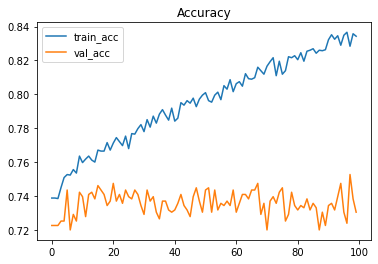

In [357]:
from matplotlib import pyplot as plt

plt.plot(epoch_accuracy_train, label="train_acc")
plt.plot(epoch_accuracy_val,label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

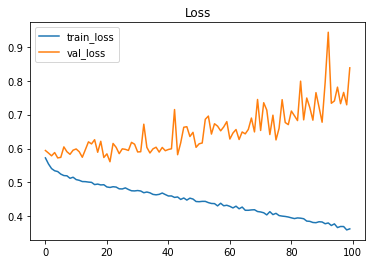

In [358]:
plt.plot(epoch_losses_train, label="train_loss")
plt.plot(epoch_losses_val,label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()